In [ ]:
from google.colab import drive
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
!pip install livelossplot

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *

from livelossplot import PlotLossesKeras

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.ensemble import *

import cv2
from PIL import Image

import numpy as np
import scipy
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm, notebook

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile
print("All modules are successfull loaded")

All modules are successfull loaded


In [ ]:
with ZipFile("./drive/MyDrive/DockShip_Hiring_Challenge/attentive_ai_internship_hiring_challenge-dataset.zip") as file:
    file.extractall()
file.close()
print("Extraction Done")

Extraction Done


In [ ]:
TRAIN_DATA = "./merged_data/train"
TEST_DATA = "./merged_data/test"
TRAIN_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/train_csv.csv"
TEST_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/test_csv.csv"
WORK_DIR = "./drive/MyDrive/DockShip_Hiring_Challenge/"

# Time to get our hands dirty

In [ ]:
train_csv = pd.read_csv(TRAIN_CSV)
test_csv = pd.read_csv(TEST_CSV)

In [ ]:
train_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)"
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)"
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)"
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)"
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)"
...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)"
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)"
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)"
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)"


In [ ]:
test_csv

,0,1,paths,img_shape
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)"
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)"
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)"
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)"
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)"
...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)"
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)"
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)"
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)"


# Augmenting data

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

for idx,(tr_,te_) in enumerate(skf.split(train_csv["paths"],y=train_csv["1"])):
    train_csv.loc[te_,'kfold']=idx

In [ ]:
train_csv

,0,1,paths,img_shape,kfold
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",2.0
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",1.0
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",4.0
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",4.0
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",0.0
...,...,...,...,...,...
8639,8639.jpg,Adhered,./merged_data/train/8639.jpg,"(3, 1502, 1598)",2.0
8640,8640.jpg,Adhered,./merged_data/train/8640.jpg,"(3, 1674, 358)",0.0
8641,8641.jpg,Adhered,./merged_data/train/8641.jpg,"(3, 4070, 6005)",3.0
8642,8642.jpg,Adhered,./merged_data/train/8642.jpg,"(3, 294, 493)",0.0


In [ ]:
len(os.listdir("./merged_data/train"))

8644

In [ ]:
def dataAugmentWithSkf(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1"):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    trainGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                  rotation_range = 270,
                                  zoom_range = 0.2,
                                #   cval = 0.,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                #   shear_range = 0.15,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  brightness_range = [0.2, 0.5],
                                  rescale = 1/255.,                       
                                )

    train_set = trainGen.flow_from_dataframe(train_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )

    valGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                rescale = 1/255.                                
                                )

    val_set = valGen.flow_from_dataframe(val_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
       
    return train_set, val_set

In [ ]:
img_shape = [224, 224]
train_set, val_set = dataAugmentWithSkf(train_csv,
                                        img_shape,
                                        x_col = "0",
                                        y_col = '1',
                                        )

Found 6915 validated image filenames belonging to 6 classes.
Found 1729 validated image filenames belonging to 6 classes.


In [ ]:
classes = train_set.class_indices
classes

{'Adhered': 0,
 'Ballasted': 1,
 'Concrete': 2,
 'Plastic & fabric': 3,
 'Shingle': 4,
 'Steel': 5}

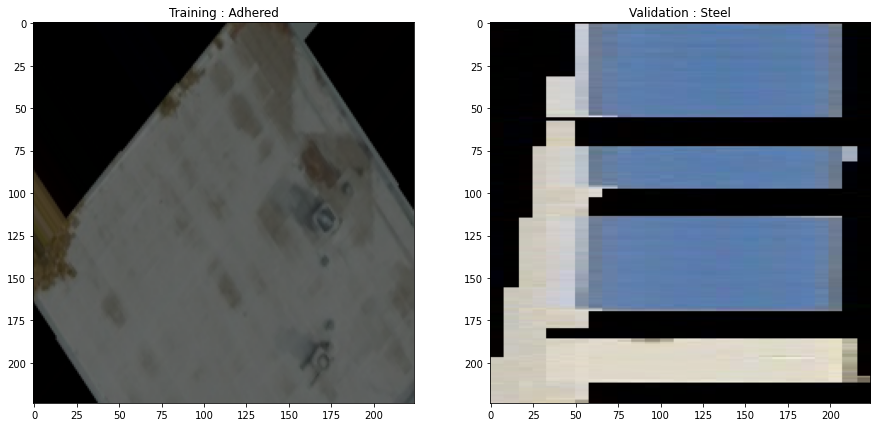

In [ ]:
idx = np.random.randint(len(next(train_set)[0]))
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow((next(train_set)[0][idx]));
plt.title(f"Training : {list(classes.keys())[list(next(train_set)[1][idx]).index(1)]}")

plt.subplot(1, 2, 2)
plt.imshow((next(val_set)[0][idx]));
plt.title(f"Validation : {list(classes.keys())[list(next(val_set)[1][idx]).index(1)]}")
plt.show();

# Building a model

In [ ]:
def create_model(img_shape = 224, n_classes = 6):

    pmodel = ResNet50V2(input_shape = (img_shape, img_shape, 3), include_top = False,
                             weights = 'imagenet')
    layer_count = 0
    untrained_layers = 0
    tlayers = len(list(pmodel.layers))
    print(f"Total layers : {tlayers}")
    # print(f"last layer_name : {list(pmodel.layers)[len(pmodel.layers)-1].name}")
    for layer in pmodel.layers:
        layer_count += 1
        if layer_count > tlayers//2:
            layer.trainable = True
            print(layer.name)
            untrained_layers += 1
        else:
            layer.trainable = False
    print(f"Total Trainable Layers : {untrained_layers}")
    # print(pmodel.name)
    x = GlobalAveragePooling2D()(pmodel.output)
    # x = Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)
    # x = Dropout(0.5)(x)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(inputs = pmodel.input, outputs = output, name = pmodel.name)
    return model

model = create_model()

Total layers : 190
conv4_block1_0_conv
conv4_block1_3_conv
conv4_block1_out
conv4_block2_preact_bn
conv4_block2_preact_relu
conv4_block2_1_conv
conv4_block2_1_bn
conv4_block2_1_relu
conv4_block2_2_pad
conv4_block2_2_conv
conv4_block2_2_bn
conv4_block2_2_relu
conv4_block2_3_conv
conv4_block2_out
conv4_block3_preact_bn
conv4_block3_preact_relu
conv4_block3_1_conv
conv4_block3_1_bn
conv4_block3_1_relu
conv4_block3_2_pad
conv4_block3_2_conv
conv4_block3_2_bn
conv4_block3_2_relu
conv4_block3_3_conv
conv4_block3_out
conv4_block4_preact_bn
conv4_block4_preact_relu
conv4_block4_1_conv
conv4_block4_1_bn
conv4_block4_1_relu
conv4_block4_2_pad
conv4_block4_2_conv
conv4_block4_2_bn
conv4_block4_2_relu
conv4_block4_3_conv
conv4_block4_out
conv4_block5_preact_bn
conv4_block5_preact_relu
conv4_block5_1_conv
conv4_block5_1_bn
conv4_block5_1_relu
conv4_block5_2_pad
conv4_block5_2_conv
conv4_block5_2_bn
conv4_block5_2_relu
conv4_block5_3_conv
conv4_block5_out
conv4_block6_preact_bn
conv4_block6_preact_r

In [ ]:
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

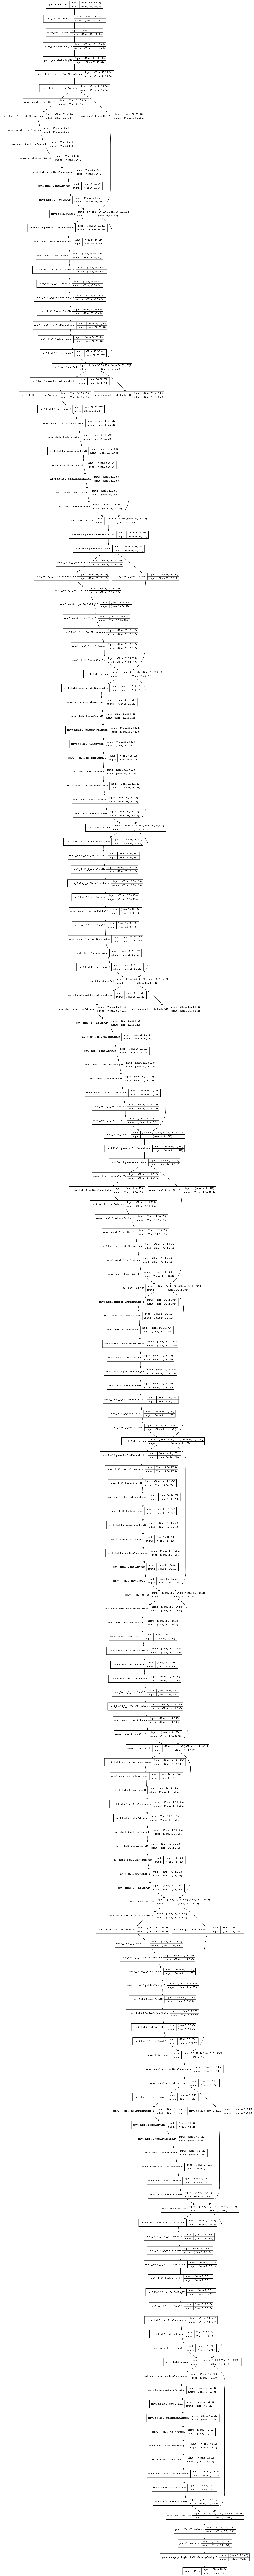

In [ ]:
plot_model(model, to_file=os.path.join(WORK_DIR, f"{model.name}.png"), show_shapes=True, show_layer_names=True)

In [ ]:
# class_weights = {}
# sum = 0
# for class_ in classes:
#     class_weights[classes[class_]] = 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
#     sum += 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
# class_weights

In [ ]:
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, 
                              verbose=1, mode='min', min_lr = 1e-7)

model_Best_save = ModelCheckpoint(f"/content/ModelCheckpoints/{model.name}.h5",
                                                    monitor = "val_loss",
                                                    save_weights = True,
                                                    save_best_only = True,
                                                    mode = "min"
                                                    )
LR = 1e-3
model.compile(loss = 'categorical_crossentropy',
            #   loss_weights= class_weights,
              metrics = ['accuracy', 'AUC'],
              optimizer = Adam(lr = LR)
              )

callbacks = [model_Best_save, early_stop, reduce_lr]

In [ ]:
training_history = model.fit(train_set,
                             validation_data = val_set,
                             callbacks = callbacks,
                             epochs = n_epoch,
                            #  class_weight = class_weights,
                             verbose = 1)

Epoch 1/50
109/109 [==============================] - 214s 2s/step - loss: 1.3214 - accuracy: 0.5013 - auc: 0.8208 - val_loss: 31.0592 - val_accuracy: 0.3545 - val_auc: 0.6458
Epoch 2/50
109/109 [==============================] - 198s 2s/step - loss: 0.9117 - accuracy: 0.6572 - auc: 0.9166 - val_loss: 14.0618 - val_accuracy: 0.3210 - val_auc: 0.6238
Epoch 3/50
109/109 [==============================] - 198s 2s/step - loss: 0.8413 - accuracy: 0.6778 - auc: 0.9284 - val_loss: 1.1142 - val_accuracy: 0.6327 - val_auc: 0.9115
Epoch 4/50
109/109 [==============================] - 197s 2s/step - loss: 0.7619 - accuracy: 0.7143 - auc: 0.9415 - val_loss: 0.9043 - val_accuracy: 0.6732 - val_auc: 0.9254
Epoch 5/50
109/109 [==============================] - 198s 2s/step - loss: 0.7027 - accuracy: 0.7291 - auc: 0.9496 - val_loss: 0.9313 - val_accuracy: 0.6854 - val_auc: 0.9245
Epoch 6/50
109/109 [==============================] - 198s 2s/step - loss: 0.6843 - accuracy: 0.7423 - auc: 0.9522 - val_lo

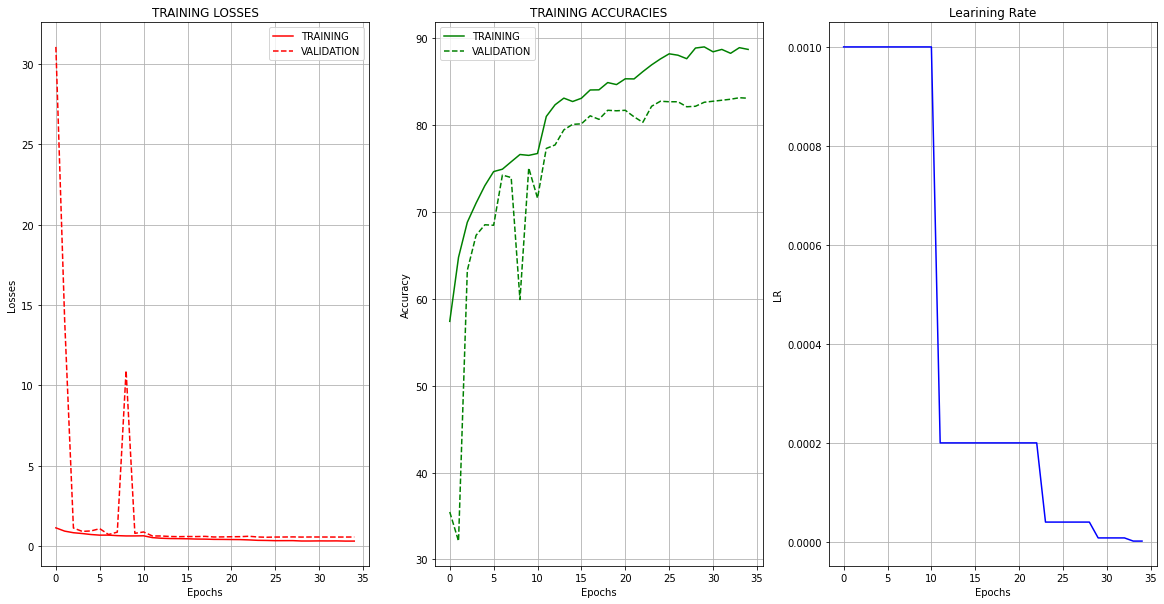

In [ ]:
epochs = [d for d in range(len(training_history.history['loss']))]
loss = training_history.history['loss']; val_loss = training_history.history['val_loss']
acc = [d*100 for d in training_history.history['accuracy']]; val_acc = [d*100 for d in training_history.history['val_accuracy']]
lr = training_history.history['lr']

plt.figure(figsize = (20, 10))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, "-r", )
plt.plot(epochs, val_loss, "--r", )
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING LOSSES")

plt.subplot(1, 3, 2)
plt.plot(epochs, acc, "-g")
plt.plot(epochs, val_acc, "--g")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING ACCURACIES")

plt.subplot(1, 3, 3)
plt.plot(epochs, lr, "-b")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("LR")
plt.title("Learining Rate")

plt.savefig(os.path.join(WORK_DIR, f"{model.name}_training_history.png"));
plt.show();

model.save(os.path.join(WORK_DIR, f"{model.name}_{val_acc[-1]}.h5"))

# Performing a submission


In [ ]:
os.listdir(WORK_DIR)

['attentive_ai_internship_hiring_challenge-dataset.zip',
 'sample_imgs.png',
 'effb0_avg_pretrained.png',
 'train_csv.csv',
 'test_csv.csv',
 'ResNet50_notTrained.png',
 'ResNet50_52.h5',
 'EffNet0_notTrained.png',
 'EffNetB0_training_history.png',
 'EffNetB0_67.09080338478088.h5',
 'EffNet0_preTrained.png',
 'ResNet50_preTrained.png',
 'ResNet50',
 'ResNet50_35.62752902507782.h5',
 'ResNet50_training_history.png',
 'ResNet50.png',
 'DockShip_BaseLineModel.ipynb',
 'resnet50v2.png',
 'Transfer Learning for Optical Satellite Images.pdf',
 'resnet50v2_training_history.png',
 'resnet50v2_83.1116259098053.h5']

In [ ]:
sub_model = load_model(os.path.join(WORK_DIR, 'resnet50v2_83.1116259098053.h5'))

In [ ]:
sub_model.evaluate(val_set)

28/28 [==============================] - 23s 761ms/step - loss: 0.5399 - accuracy: 0.8276 - auc: 0.9699


[0.5399428606033325, 0.827646017074585, 0.9699448943138123]

In [ ]:
sub_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
# test_imgs = []; train_imgs = []
# for img_path in tqdm(test_csv.paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     test_imgs.append(img)

# for img_path in tqdm(train_csv.iloc[:len(test_csv), :].paths):
#     img = cv2.imread(img_path)
#     img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (224, 224))
#     img = img/255.
#     train_imgs.append(img)

# test_imgs = np.array(test_imgs)
# train_imgs = np.array(train_imgs)

100%|██████████| 596/596 [00:02<00:00, 209.24it/s]


In [ ]:
test_imgs.shape, train_imgs.shape

((596, 224, 224, 3), (596, 224, 224, 3))

In [ ]:
def giveMeClass(x):
    for key, val in classes.items():
        if val == x:
            return key
    return -1

test_preds = sub_model.predict(test_imgs)
train_preds = sub_model.predict(train_imgs)
tpreds = []
trpreds = []
for test_pred in tqdm(test_preds):
    tpreds.append(np.argmax(test_pred))

for train_pred in tqdm(train_preds):
    trpreds.append(np.argmax(train_pred))

train_check = train_csv.iloc[:len(test_csv), :]

train_check['Model_preds'] = trpreds
train_check['Model_preds'] = train_check['Model_preds'].apply(lambda x: giveMeClass(x))

test_csv['Model_preds'] = tpreds
test_csv['Model_preds'] = test_csv['Model_preds'].apply(lambda x: giveMeClass(x))

100%|██████████| 596/596 [00:00<00:00, 79495.17it/s]


In [ ]:
train_check

,0,1,paths,img_shape,kfold,Model_preds
0,0.jpg,Adhered,./merged_data/train/0.jpg,"(3, 1063, 461)",2.0,Adhered
1,1.jpg,Adhered,./merged_data/train/1.jpg,"(3, 190, 282)",1.0,Adhered
2,2.jpg,Concrete,./merged_data/train/2.jpg,"(3, 80, 72)",4.0,Concrete
3,3.jpg,Concrete,./merged_data/train/3.jpg,"(3, 103, 73)",4.0,Concrete
4,4.jpg,Plastic & fabric,./merged_data/train/4.jpg,"(3, 150, 120)",0.0,Plastic & fabric
...,...,...,...,...,...,...
591,591.jpg,Steel,./merged_data/train/591.jpg,"(3, 112, 127)",1.0,Adhered
592,592.jpg,Plastic & fabric,./merged_data/train/592.jpg,"(3, 556, 666)",4.0,Plastic & fabric
593,593.jpg,Plastic & fabric,./merged_data/train/593.jpg,"(3, 719, 119)",0.0,Plastic & fabric
594,594.jpg,Plastic & fabric,./merged_data/train/594.jpg,"(3, 196, 166)",1.0,Plastic & fabric


In [ ]:
test_csv

,0,1,paths,img_shape,Model_preds
0,0.jpg,Adhered,./merged_data/test/0.jpg,"(3, 609, 388)",Ballasted
1,1.jpg,Adhered,./merged_data/test/1.jpg,"(3, 90, 43)",Steel
2,2.jpg,Adhered,./merged_data/test/2.jpg,"(3, 211, 365)",Ballasted
3,3.jpg,Adhered,./merged_data/test/3.jpg,"(3, 1818, 913)",Concrete
4,4.jpg,Adhered,./merged_data/test/4.jpg,"(3, 433, 105)",Steel
...,...,...,...,...,...
591,591.jpg,Adhered,./merged_data/test/591.jpg,"(3, 4080, 3220)",Plastic & fabric
592,592.jpg,Adhered,./merged_data/test/592.jpg,"(3, 635, 682)",Steel
593,593.jpg,Adhered,./merged_data/test/593.jpg,"(3, 117, 284)",Plastic & fabric
594,594.jpg,Adhered,./merged_data/test/594.jpg,"(3, 901, 720)",Ballasted


In [ ]:
print(classification_report(test_csv['1'], test_csv['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       1.00      0.17      0.29       596
       Ballasted       0.00      0.00      0.00         0
        Concrete       0.00      0.00      0.00         0
Plastic & fabric       0.00      0.00      0.00         0
         Shingle       0.00      0.00      0.00         0
           Steel       0.00      0.00      0.00         0

        accuracy                           0.17       596
       macro avg       0.17      0.03      0.05       596
    weighted avg       1.00      0.17      0.29       596



In [ ]:
print(classification_report(train_check['1'], train_check['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       0.89      0.85      0.87       366
       Ballasted       0.74      0.89      0.81        19
        Concrete       0.67      0.72      0.70        65
Plastic & fabric       0.80      0.75      0.77        57
         Shingle       1.00      0.89      0.94        35
           Steel       0.60      0.78      0.68        54

        accuracy                           0.82       596
       macro avg       0.78      0.81      0.79       596
    weighted avg       0.83      0.82      0.83       596



In [ ]:
submission = test_csv[['0', 'Model_preds']]
submission.rename({'Model_preds': "1"}, axis = 1, inplace = True)
submission.to_csv('output.csv', index = False)
submission

,0,1
0,0.jpg,Ballasted
1,1.jpg,Steel
2,2.jpg,Ballasted
3,3.jpg,Concrete
4,4.jpg,Steel
...,...,...
591,591.jpg,Plastic & fabric
592,592.jpg,Steel
593,593.jpg,Plastic & fabric
594,594.jpg,Ballasted
